# Tutorial 2: Effects of Input Correlation

**Week 2, Day 3: Biological Neuron Models**

**By Neuromatch Academy**

__Content creators:__ Qinglong Gu, Songtin Li, John Murray, Richard Naud, Arvind Kumar

__Content reviewers:__ Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Matthew Krause, Spiros Chavlis, Michael Waskom

**Post-Production team:** Gagana B, Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

In this tutorial, we will use the leaky integrate-and-fire (LIF) neuron model (see Tutorial 1) to study how they transform input correlations to output properties (transfer of correlations). In particular, we are going to write a few lines of code to:

- inject correlated GWN in a pair of neurons

- measure correlations between the spiking activity of the two neurons

- study how the transfer of correlation depends on the statistics of the input, i.e. mean and standard deviation.

---
# Summary

*Estimated timing of tutorial: 50 minutes*

In this tutorial, we studied how the input correlation of two LIF neurons is mapped to their output correlation. Specifically, we:

- injected correlated GWN in a pair of neurons,

- measured correlations between the spiking activity of the two neurons, and

- studied how the transfer of correlation depends on the statistics of the input, i.e., mean and standard deviation.

Here, we were concerned with zero time lag correlation. For this reason, we restricted estimation of correlation to instantaneous correlations. If you are interested in time-lagged correlation, then we should estimate the cross-correlogram of the spike trains and find out the dominant peak and area under the peak to get an estimate of output correlations.

We leave this as a future to-do for you if you are interested.

If you have time, check out the bonus video to think about responses of ensembles of neurons to time-varying input.

---
# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
# @title Plotting Functions

def example_plot_myCC():
  pars = default_pars(T=50000, dt=.1)

  c = np.arange(10) * 0.1
  r12 = np.zeros(10)
  for i in range(10):
    I1gL, I2gL = correlate_input(pars, mu=20.0, sig=7.5, c=c[i])
    r12[i] = my_CC(I1gL, I2gL)

  plt.figure()
  plt.plot(c, r12, 'bo', alpha=0.7, label='Simulation', zorder=2)
  plt.plot([-0.05, 0.95], [-0.05, 0.95], 'k--', label='y=x',
           dashes=(2, 2), zorder=1)
  plt.xlabel('True CC')
  plt.ylabel('Sample CC')
  plt.legend(loc='best')
  plt.show()


def my_raster_Poisson(range_t, spike_train, n):
  """
  Ffunction generates and plots the raster of the Poisson spike train

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  plt.figure()
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)
  plt.show()

def plot_c_r_LIF(c, r, mycolor, mylabel):
  z = np.polyfit(c, r, deg=1)
  c_range = np.array([c.min() - 0.05, c.max() + 0.05])
  plt.plot(c, r, 'o', color=mycolor, alpha=0.7, label=mylabel, zorder=2)
  plt.plot(c_range, z[0] * c_range + z[1], color=mycolor, zorder=1)

In [4]:
# @title Helper Functions
def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized
                                                         # time points [ms]
  return pars


def run_LIF(pars, Iinj):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value or an array

  Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, V_L = pars['V_init'], pars['V_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  tr = 0.

  # simulate the LIF dynamics
  rec_spikes = []   # record spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - V_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


def my_GWN(pars, sig, myseed=False):
  """
  Function that calculates Gaussian white noise inputs

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed. You can fix the seed of the random number generator so
  # that the results are reliable however, when you want to generate multiple
  # realization make sure that you change the seed for each new realization
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_GWN = sig * np.random.randn(Lt) * np.sqrt(pars['tau_m'] / dt)

  return I_GWN


def LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20):
  """ Simulates two LIF neurons with correlated input and computes output correlation

  Args:
  pars       : parameter dictionary
  mu         : noise baseline (mean)
  sig        : noise amplitute (standard deviation)
  c          : correlation coefficient ~[0, 1]
  bin_size   : bin size used for time series
  n_trials   : total simulation trials

  Returns:
  r          : output corr. coe.
  sp_rate    : spike rate
  sp1        : spike times of neuron 1 in the last trial
  sp2        : spike times of neuron 2 in the last trial
  """

  r12 = np.zeros(n_trials)
  sp_rate = np.zeros(n_trials)
  for i_trial in range(n_trials):
    I1gL, I2gL = correlate_input(pars, mu, sig, c)
    _, sp1 = run_LIF(pars, pars['g_L'] * I1gL)
    _, sp2 = run_LIF(pars, pars['g_L'] * I2gL)

    my_bin = np.arange(0, pars['T'], bin_size)

    sp1_count, _ = np.histogram(sp1, bins=my_bin)
    sp2_count, _ = np.histogram(sp2, bins=my_bin)

    r12[i_trial] = my_CC(sp1_count[::20], sp2_count[::20])
    sp_rate[i_trial] = len(sp1) / pars['T'] * 1000.

  return r12.mean(), sp_rate.mean(), sp1, sp2

The helper function contains the:

- Parameter dictionary: `default_pars( **kwargs)` from Tutorial 1
- LIF simulator: `run_LIF` from Tutorial 1
- Gaussian white noise generator: `my_GWN(pars, sig, myseed=False)` from Tutorial 1
- Poisson type spike train generator: `Poisson_generator(pars, rate, n, myseed=False)`
- Two LIF neurons with correlated inputs simulator: `LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20)`


---
# Section 1: Correlations (Synchrony)
Correlation or synchrony in neuronal activity can be described for any readout of brain activity. Here, we are concerned with the spiking activity of neurons.

In the simplest way, correlation/synchrony refers to coincident spiking of neurons, i.e., when two neurons spike together, they are firing in **synchrony** or are **correlated**. Neurons can be synchronous in their instantaneous activity, i.e., they spike together with some probability. However, it is also possible that spiking of a neuron at time $t$ is correlated with the spikes of another neuron with a delay (time-delayed synchrony).

## Origin of synchronous neuronal activity:
- Common inputs, i.e., two neurons are receiving input from the same sources. The degree of correlation of the shared inputs is proportional to their output correlation.
- Pooling from the same sources. Neurons do not share the same input neurons but are receiving inputs from neurons which themselves are correlated.
- Neurons are connected to each other (uni- or bi-directionally): This will only give rise to time-delayed synchrony. Neurons could also be connected via gap-junctions.
- Neurons have similar parameters and initial conditions.

## Implications of synchrony
When neurons spike together, they can have a stronger impact on downstream neurons. Synapses in the brain are sensitive to the temporal correlations (i.e., delay) between pre- and postsynaptic activity, and this, in turn, can lead to the formation of functional neuronal networks - the basis of unsupervised learning (we will study some of these concepts in a forthcoming tutorial).

Synchrony implies a reduction in the dimensionality of the system. In addition, correlations, in many cases, can impair the decoding of neuronal activity.

A simple model to study the emergence of correlations is to inject common inputs to a pair of neurons and measure the output correlation as a function of the fraction of common inputs.

Here, we are going to investigate the transfer of correlations by computing the correlation coefficient of spike trains recorded from two unconnected LIF neurons, which received correlated inputs.


The input current to LIF neuron $i$ $(i=1,2)$ is:

\begin{equation}
\frac{I_i}{g_L} = \mu_i + \sigma_i (\sqrt{1-c}\xi_i + \sqrt{c}\xi_c) \quad (1)
\end{equation}

where $\mu_i$ is the temporal average of the current. The Gaussian white noise $\xi_i$ is independent for each neuron, while $\xi_c$ is common to all neurons. The variable $c$ ($0\le c\le1$) controls the fraction of common and independent inputs. $\sigma_i$ shows the variance of the total input.

So, first, we will generate correlated inputs.

In [5]:
# @markdown Execute this cell to get a function `correlate_input` for generating correlated GWN inputs
def correlate_input(pars, mu=20., sig=7.5, c=0.3):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    c.         : correlation coefficient ~[0, 1]

  Returns:
    I1gL, I2gL : two correlated inputs with corr. coe. c
  """

  # generate Gaussian whute noise xi_1, xi_2, xi_c
  xi_1 = my_GWN(pars, sig)
  xi_2 = my_GWN(pars, sig)
  xi_c = my_GWN(pars, sig)

  # Generate two correlated inputs by Equation. (1)
  I1gL = mu + np.sqrt(1. - c) * xi_1 + np.sqrt(c) * xi_c
  I2gL = mu + np.sqrt(1. - c) * xi_2 + np.sqrt(c) * xi_c

  return I1gL, I2gL

help(correlate_input)

Help on function correlate_input in module __main__:

correlate_input(pars, mu=20.0, sig=7.5, c=0.3)
    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      c.         : correlation coefficient ~[0, 1]

    Returns:
      I1gL, I2gL : two correlated inputs with corr. coe. c



## Coding Exercise 1A: Compute the correlation

The _sample correlation coefficient_ between two input currents $I_i$ and $I_j$ is defined as the sample covariance of $I_i$ and $I_j$ divided by the square root of the sample variance of $I_i$ multiplied with the square root of the sample variance of $I_j$. In equation form:

\begin{align}
r_{ij} &= \frac{cov(I_i, I_j)}{\sqrt{var(I_i)} \sqrt{var(I_j)}}\\
cov(I_i, I_j) &= \sum_{k=1}^L (I_i^k -\bar{I_i})(I_j^k -\bar{I_j}) \\
var(I_i) &= \sum_{k=1}^L (I_i^k -\bar{I}_i)^2
\end{align}

where $\bar{I_i}$ is the sample mean, $k$ is the time bin, and $L$ is the length of $I$. This means that $I_i^k$ is current $i$ at time $k\cdot dt$.

<br>

**Important note:** The equations above are not accurate for sample covariances and variances as they should be additionally divided by $L-1$. We have dropped this term because it cancels out in the sample correlation coefficient formula.

<br>

The _sample correlation coefficient_ may also be referred to as the _sample Pearson correlation coefficient_. Here, is a beautiful paper that explains multiple ways to calculate and understand correlations [Rodgers and Nicewander 1988](https://www.stat.berkeley.edu/~rabbee/correlation.pdf).

In this exercise, we will create a function, `my_CC` to compute the sample correlation coefficient between two time series. Note that while we introduced this computation here in the context of input currents, the sample correlation coefficient is used to compute the correlation between any two time series - we will use it later on binned spike trains.

We then check our method is accurate by generating currents with a certain correlation (using `correlate_input`), computing the correlation coefficient using `my_CC`, and plotting the true vs sample correlation coefficients.

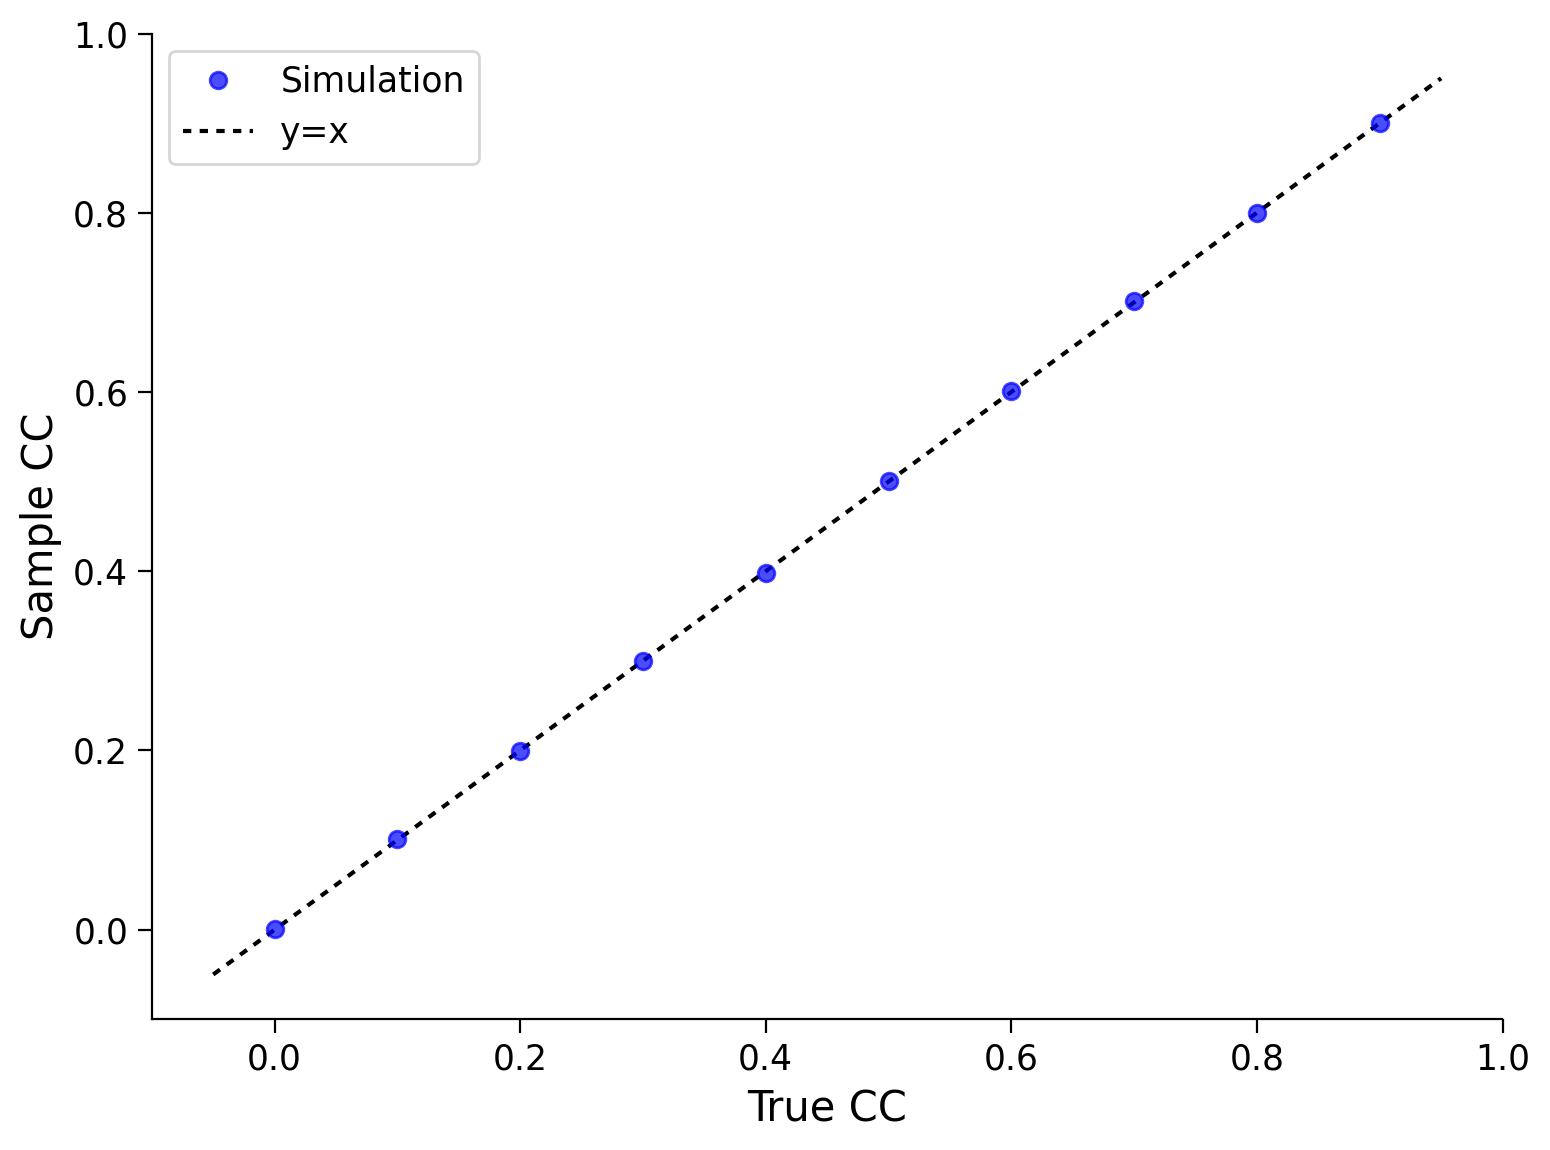

In [7]:
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """
  ########################################################################
  ## TODO for students: compute rxy, then remove the NotImplementedError #
  # Tip1: array([a1, a2, a3])*array([b1, b2, b3]) = array([a1*b1, a2*b2, a3*b3])
  # Tip2: np.sum(array([a1, a2, a3])) = a1+a2+a3
  # Tip3: square root, np.sqrt()
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: compute the sample correlation coefficient")
  ########################################################################

  # Calculate the covariance of i and j
  cov = np.sum((i - np.mean(i)) * (j-np.mean(j)))

  # Calculate the variance of i
  var_i = np.sum((i - np.mean(i))**2)

  # Calculate the variance of j
  var_j = np.sum((j - np.mean(j))**2)

  # Calculate the correlation coefficient
  rij = (cov)/(np.sqrt(var_i)*np.sqrt(var_j))

  return rij


example_plot_myCC()

The sample correlation coefficients (computed using `my_CC`) match the ground truth correlation coefficient!

In the next exercise, we will use the Poisson distribution to model spike trains. Remember that you have seen the Poisson distribution used in this way in the [pre-reqs math day on Statistics](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial1.html#section-2-2-poisson-distribution). Remember that a Poisson spike train has the following properties:
- The ratio of the mean and variance of spike count is 1
- Inter-spike-intervals are exponentially distributed
- Spike times are irregular i.e. 𝐶𝑉ISI=1
- Adjacent spike intervals are independent of each other.

In the following cell, we provide a helper function `Poisson_generator` and then use it to produce a Poisson spike train.

In [8]:
# @markdown Execute this cell to get helper function `Poisson_generator`
def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

help(Poisson_generator)

Help on function Poisson_generator in module __main__:

Poisson_generator(pars, rate, n, myseed=False)
    Generates poisson trains

    Args:
      pars       : parameter dictionary
      rate       : noise amplitute [Hz]
      n          : number of Poisson trains
      myseed     : random seed. int or boolean

    Returns:
      pre_spike_train : spike train matrix, ith row represents whether
                        there is a spike in ith spike train over time
                        (1 if spike, 0 otherwise)



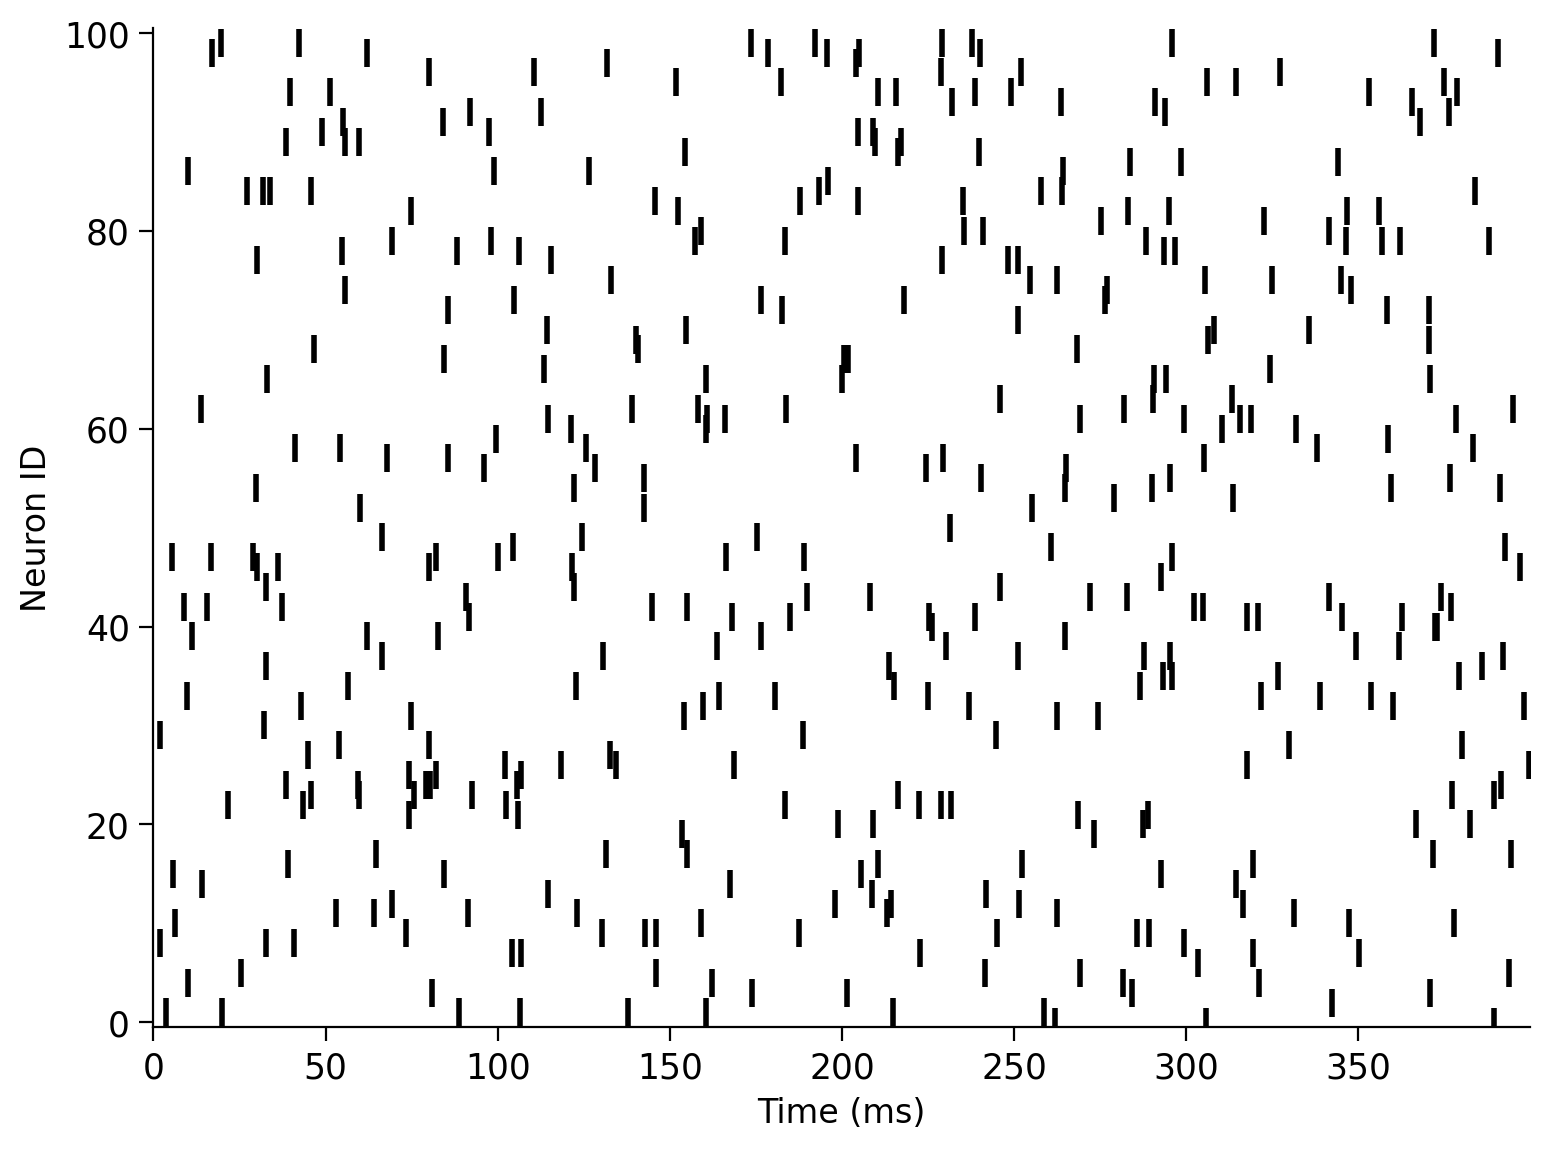

In [9]:
# @markdown Execute this cell to visualize Poisson spike train

pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)

## Coding Exercise 1B: Measure the correlation between spike trains

After recording the spike times of the two neurons, how can we estimate their correlation coefficient?

In order to find this, we need to bin the spike times and obtain two time series. Each data point in the time series is the number of spikes in the corresponding time bin. You can use `np.histogram()` to bin the spike times.

Complete the code below to bin the spike times and calculate the correlation coefficient for two Poisson spike trains. Note that `c` here is the ground-truth correlation coefficient that we define.



In [10]:
# @markdown Execute this cell to get a function for generating correlated Poisson inputs (`generate_corr_Poisson`)


def generate_corr_Poisson(pars, poi_rate, c, myseed=False):
  """
  function to generate correlated Poisson type spike trains
  Args:
    pars       : parameter dictionary
    poi_rate   : rate of the Poisson train
    c.         : correlation coefficient ~[0, 1]

  Returns:
    sp1, sp2   : two correlated spike time trains with corr. coe. c
  """

  range_t = pars['range_t']

  mother_rate = poi_rate / c
  mother_spike_train = Poisson_generator(pars, rate=mother_rate,
                                         n=1, myseed=myseed)[0]
  sp_mother = range_t[mother_spike_train > 0]

  L_sp_mother = len(sp_mother)
  sp_mother_id = np.arange(L_sp_mother)
  L_sp_corr = int(L_sp_mother * c)

  np.random.shuffle(sp_mother_id)
  sp1 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  np.random.shuffle(sp_mother_id)
  sp2 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  return sp1, sp2

print(help(generate_corr_Poisson))

Help on function generate_corr_Poisson in module __main__:

generate_corr_Poisson(pars, poi_rate, c, myseed=False)
    function to generate correlated Poisson type spike trains
    Args:
      pars       : parameter dictionary
      poi_rate   : rate of the Poisson train
      c.         : correlation coefficient ~[0, 1]

    Returns:
      sp1, sp2   : two correlated spike time trains with corr. coe. c

None


In [15]:
def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(trials)

  for i in range(trials):
    ##############################################################
    ## TODO for students
    # Note that you can run multiple realizations and compute their r_12(diff_trials)
    # with the defined function above. The average r_12 over trials can get close to c.
    # Note: change seed to generate different input per trial
    # Fill out function and remove
    # raise NotImplementedError("Student exercise: compute the correlation coefficient")
    ##############################################################

    # Generate correlated Poisson inputs
    sp1, sp2 = generate_corr_Poisson(pars, poi_rate=rate, c=c, myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(sp1, bins=bins)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(sp2, bins=bins)

    # Calculate the correlation coefficient
    r12[i] = my_CC(sp1_count, sp2_count)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)

# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
print(f'True corr coe = {c:.3f}')
print(f'Simu corr coe = {r12.mean():.3f}')

True corr coe = 0.200
Simu corr coe = 0.197


---
# Section 2: Investigate the effect of input correlation on the output correlation

*Estimated timing to here from start of tutorial: 20 min*

Now let's combine the aforementioned two procedures. We first generate the correlated inputs. Then we inject the correlated inputs $I_1, I_2$ into a pair of neurons and record their output spike times. We continue measuring the correlation between the output and
investigate the relationship between the input correlation and the output correlation.


In the following, you will inject correlated GWN in two neurons. You need to define the mean (`gwn_mean`), standard deviation (`gwn_std`), and input correlations (`c_in`).

We will simulate $10$ trials to get a better estimate of the output correlation. Change the values in the following cell for the above variables (and then run the next cell) to explore how they impact the output correlation.

In [22]:
# Play around with these parameters

pars = default_pars(T=80000, dt=1.)  # get the parameters
c_in = 0.3  # set input correlation value
gwn_mean = 5.
gwn_std = 50.

Simulation time = 0.03 min
Input correlation = 0.3
Output correlation = 0.178540251287461


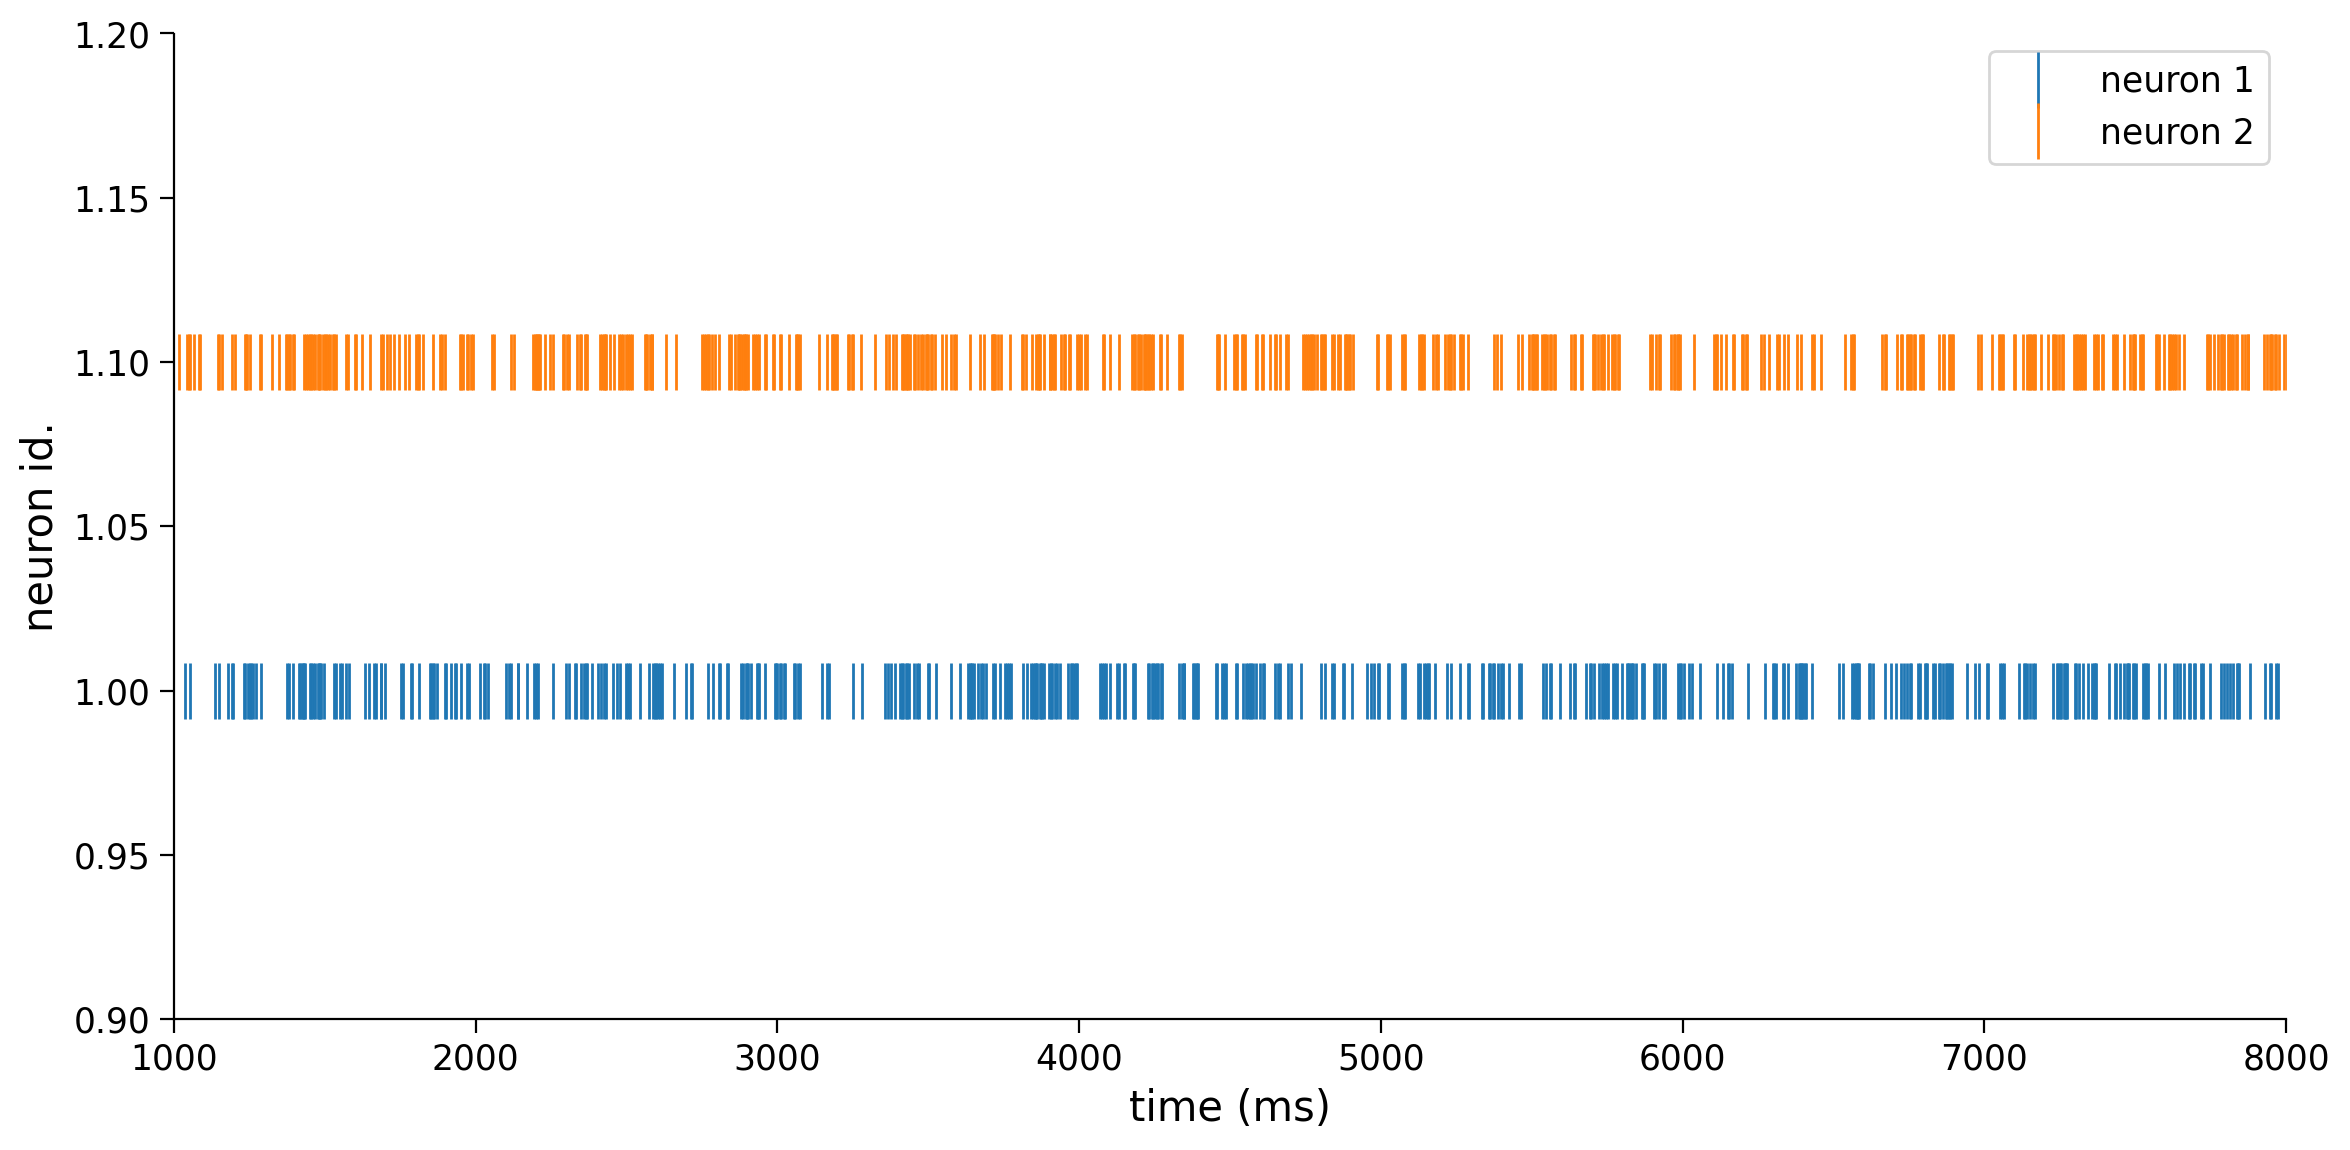

In [23]:
# @markdown Do not forget to execute this cell to simulate the LIF

bin_size = 10.  # ms
starttime = time.perf_counter()  # time clock
r12_ss, sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=gwn_mean, sig=gwn_std, c=c_in,
                                        bin_size=bin_size, n_trials=10)

# just the time counter
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

print(f"Input correlation = {c_in}")
print(f"Output correlation = {r12_ss}")

plt.figure(figsize=(12, 6))
plt.plot(sp1, np.ones(len(sp1)) * 1, '|', ms=20, label='neuron 1')
plt.plot(sp2, np.ones(len(sp2)) * 1.1, '|', ms=20, label='neuron 2')
plt.xlabel('time (ms)')
plt.ylabel('neuron id.')
plt.xlim(1000, 8000)
plt.ylim(0.9, 1.2)
plt.legend()
plt.show()

## Think! 2: Input and Output Correlations
- Is the output correlation always smaller than the input correlation? If yes, why?
- Should there be a systematic relationship between input and output correlations?

You will explore these questions in the next figure but try to develop your own intuitions first!

Let's vary `c_in` and plot the relationship between the `c_in` and output correlation. This might take some time depending on the number of trials.

Simulation time = 0.32 min


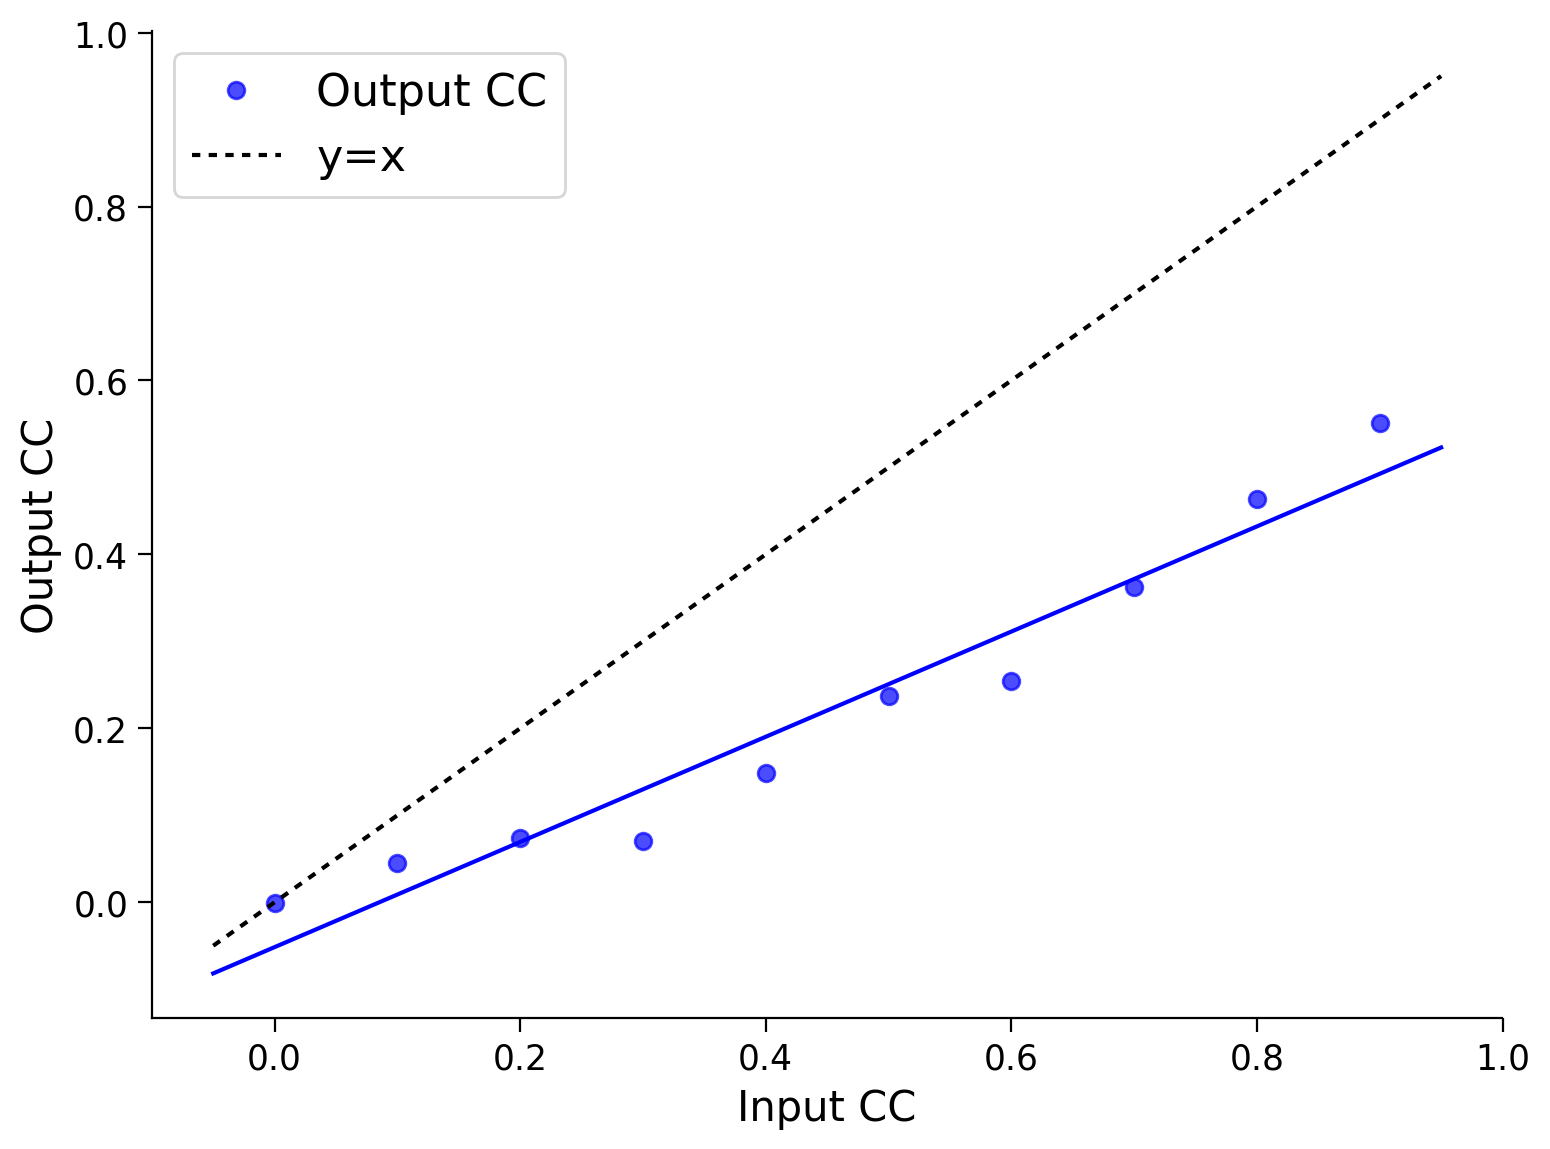

In [24]:
# @markdown Don't forget to execute this cell!

pars = default_pars(T=80000, dt=1.)  # get the parameters
bin_size = 10.
c_in = np.arange(0, 1.0, 0.1)  # set the range for input CC
r12_ss = np.zeros(len(c_in))  # small mu, small sigma

starttime = time.perf_counter() # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=10)

endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel='Output CC')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')

plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=16)
plt.show()

---
# Section 3: Correlation transfer function

*Estimated timing to here from start of tutorial: 30 min*

The above plot of input correlation vs. output correlation is called the __correlation transfer function__ of the neurons.

## Section 3.1: How do the mean and standard deviation of the Gaussian white noise (GWN) affect the correlation transfer function?

The correlations transfer function appears to be linear. The above can be taken as the input/output transfer function of LIF neurons for correlations, instead of the transfer function for input/output firing rates as we had discussed in the previous tutorial (i.e., F-I curve).

What would you expect to happen to the slope of the correlation transfer function if you vary the mean and/or the standard deviation of the GWN of the inputs ?

Simulation time = 0.52 min


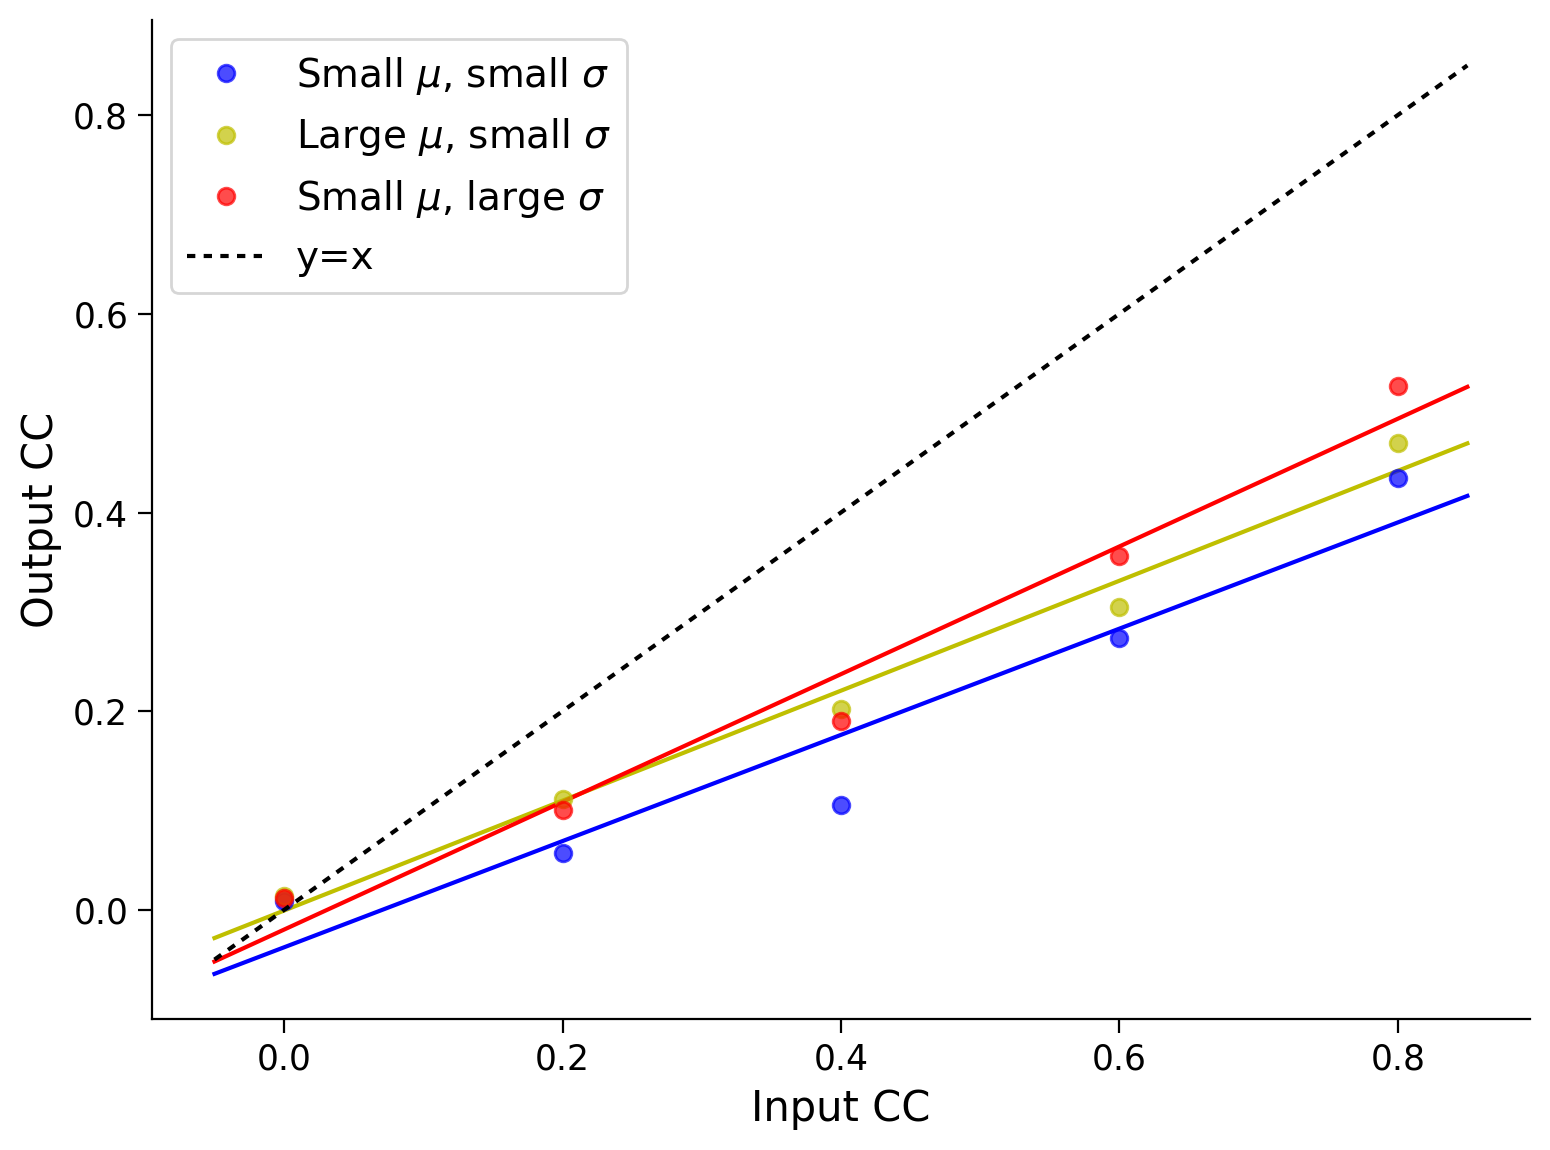

In [25]:
# @markdown Execute this cell to visualize correlation transfer functions

pars = default_pars(T=80000, dt=1.) # get the parameters
n_trials = 10
bin_size = 10.
c_in = np.arange(0., 1., 0.2)  # set the range for input CC
r12_ss = np.zeros(len(c_in))   # small mu, small sigma
r12_ls = np.zeros(len(c_in))   # large mu, small sigma
r12_sl = np.zeros(len(c_in))   # small mu, large sigma

starttime = time.perf_counter()  # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
  r12_ls[ic], sp_ls, sp1, sp2 = LIF_output_cc(pars, mu=18.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
  r12_sl[ic], sp_sl, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=20.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=n_trials)
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")


plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel=r'Small $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_ls, mycolor='y', mylabel=r'Large $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_sl, mycolor='r', mylabel=r'Small $\mu$, large $\sigma$')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')
plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=14)
plt.show()

### Think! 3.1: GWN and the Correlation Transfer Function
Why do both the mean and the standard deviation of the GWN affect the slope of the correlation transfer function?

## Section 3.2: What is the rationale behind varying $\mu$ and $\sigma$?

The mean and the variance of the synaptic current depends on the spike rate of a Poisson process. We can use something called [Campbell's theorem](https://en.wikipedia.org/wiki/Campbell%27s_theorem_(probability)) to estimate the mean and the variance of the synaptic current:

\begin{align}
\mu_{\rm syn} = \lambda J \int P(t) dt \\
\sigma_{\rm syn} = \lambda J \int P(t)^2 dt
\end{align}

where $\lambda$ is the firing rate of the Poisson input, $J$ the amplitude of the postsynaptic current and $P(t)$ is the shape of the postsynaptic current as a function of time.

Therefore, when we varied $\mu$ and/or $\sigma$ of the GWN, we mimicked a change in the input firing rate. Note that, if we change the firing rate, both $\mu$ and $\sigma$ will change simultaneously, not independently.

Here, since we observe an effect of $\mu$ and $\sigma$ on correlation transfer, this implies that the input rate has an impact on the correlation transfer function.

# Think!: Correlations and Network Activity

- What are the factors that would make output correlations smaller than input correlations? (Notice that the colored lines are below the black dashed line)
- What does the fact that output correlations are smaller mean for the correlations throughout a network?
- Here we have studied the transfer of correlations by injecting GWN. But in the previous tutorial, we mentioned that GWN is unphysiological. Indeed, neurons receive colored noise (i.e., Shot noise or OU process). How do these results obtained from injection of GWN apply to the case where correlated spiking inputs are injected in the two LIFs? Will the results be the same or different?

<br>

References:

- de la Rocha J, Doiron B, Shea-Brown E, Josić K, Reyes A (2007). Correlation between neural spike trains increases with firing rate. Nature 448:802-806. doi: [10.1038/nature06028](https://doi.org/10.1038/nature06028)

- Bujan AF, Aertsen A, Kumar A (2015). Role of input correlations in shaping the variability and noise correlations of evoked activity in the neocortex, Journal of Neuroscience 35(22):8611-25. doi: [10.1523/JNEUROSCI.4536-14.2015](https://doi.org/10.1523/JNEUROSCI.4536-14.2015)

---
# Bonus

## Bonus Section 1: Ensemble Response

Finally, there is a short BONUS lecture video on the firing response of an ensemble of neurons to time-varying input. There are no associated coding exercises - just enjoy.

In [ ]:
# @title Video 2: Response of ensemble of neurons to time-varying input
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '78_dWa4VOIo'), ('Bilibili', 'BV18K4y1x7Pt')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)